In [1]:
%pylab inline
import os
from collections import defaultdict, Counter

import pandas as pd
import seaborn as sns
from PYEVALB import scorer, parser

sns.set(style="whitegrid")

Populating the interactive namespace from numpy and matplotlib


In [2]:
OUTPATH = 'figures/samples'

NUM_SENTS = 10

test_trees_path = '../data/ptb/23.auto.clean.notop'
crf_samples_path = '../data/proposals/crf-test.props'
rnng_samples_path = '../data/proposals/rnng-test.props'

In [3]:
# Copied from utils.trees (couldn't import...)
def add_dummy_tags(tree, tag='*'):
    """Turns '(NP The tagless tree)' into '(NP (* The) (* tagless) (* tree))'."""
    assert isinstance(tree, str), tree
    i = 0
    max_idx = (len(tree) - 1)
    new_tree = ''
    while i <= max_idx:
        if tree[i] == '(':
            new_tree += tree[i]
            i += 1
            while tree[i] != ' ':
                new_tree += tree[i]
                i += 1
        elif tree[i] == ')':
            new_tree += tree[i]
            if i == max_idx:
                break
            i += 1
        else: # it's a terminal symbol
            new_tree += '(' + tag + ' '
            while tree[i] not in (' ', ')'):
                new_tree += tree[i]
                i += 1
            new_tree += ')'
        while tree[i] == ' ':
            if i == max_idx:
                break
            new_tree += tree[i]
            i += 1
    assert i == max_idx, i
    return new_tree

In [4]:
def read_proposal_samples(path):
    samples = defaultdict(list)
    with open(path) as f:
        for line in f:
            index, logprob, tree = line.strip().split(' ||| ')
            samples[int(index)].append((float(logprob), tree))
    return samples


def read_gold_trees(tree_path):
    d = {}
    with open(tree_path) as f:
        for i, line in enumerate(f):
            d[i] = line.strip()
    return d


def fscore(prec, recall):
    return 2 * (prec * recall) / (prec + recall)


def evalb_samples(gold, samples):
    evalb_scorer = scorer.Scorer()
    gold_tree = parser.create_from_bracket_string(gold)
    sample_trees = [parser.create_from_bracket_string(add_dummy_tags(sample)) 
        for sample in samples]
    results = [evalb_scorer.score_trees(gold_tree, sample_tree) 
        for sample_tree in sample_trees]
    fscores = [fscore(result.prec, result.recall) for result in results]
    return fscores


def make_logprob_dataframe(rnng_samples, crf_samples, num_sents=10):
    d = dict(sentence=[], parser=[], logprob=[])
    
    for i in range(num_sents):
        samples = rnng_samples[i]
        for logprob, tree in samples:
            d['sentence'].append(i)
            d['parser'].append('rnng')
            d['logprob'].append(logprob)

    for i in range(num_sents):
        samples = crf_samples[i]
        for logprob, tree in samples:
            d['sentence'].append(i)
            d['parser'].append('crf')
            d['logprob'].append(logprob)
            
    return d


def make_fscore_dataframe(gold_trees, rnng_samples, crf_samples, num_sents=10):
    d = dict(sentence=[], parser=[], fscore=[])
    
    for i in range(num_sents):
        _, samples = zip(*rnng_samples[i])
        fscores = evalb_samples(gold_trees[i], samples)
        for fscore in fscores:
            d['sentence'].append(i)
            d['parser'].append('rnng')
            d['fscore'].append(fscore)

    for i in range(num_sents):
        _, samples = zip(*crf_samples[i])
        fscores = evalb_samples(gold_trees[i], samples)
        for fscore in fscores:
            d['sentence'].append(i)
            d['parser'].append('crf')
            d['fscore'].append(fscore)
            
    return d

def make_count_dataframe(rnng_samples, crf_samples, num_sents=10):
    d = dict(sentence=[], parser=[], count=[])
    
    for i in range(num_sents):
        _, samples = zip(*rnng_samples[i])
        counts = Counter(samples).values()
        for count in counts:
            d['sentence'].append(i)
            d['parser'].append('rnng')
            d['count'].append(count)

    for i in range(num_sents):
        _, samples = zip(*crf_samples[i])
        counts = Counter(samples).values()
        for count in counts:
            d['sentence'].append(i)
            d['parser'].append('crf')
            d['count'].append(count)
            
    return d

In [5]:
gold_trees = read_gold_trees(test_trees_path)
crf_samples = read_proposal_samples(crf_samples_path)
rnng_samples = read_proposal_samples(rnng_samples_path)

logprob_df = make_logprob_dataframe(
    rnng_samples, crf_samples, num_sents=NUM_SENTS)
fscore_df = make_fscore_dataframe(
    gold_trees, rnng_samples, crf_samples, num_sents=NUM_SENTS)
count_df = make_count_dataframe(
    rnng_samples, crf_samples, num_sents=NUM_SENTS)

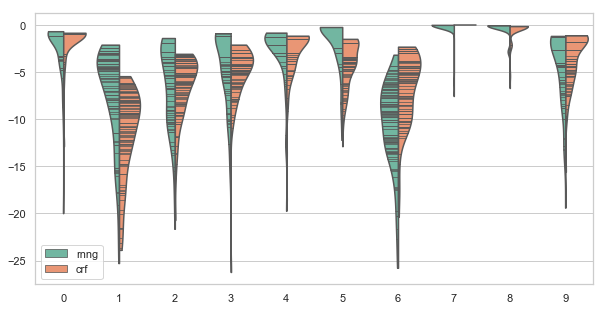

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.violinplot(ax=ax, 
               data=logprob_df, 
               x='sentence', 
               y='logprob', 
               hue='parser', 
               split=True, 
               palette='Set2', 
               inner='sticks',
               cut=0)
plt.savefig(os.path.join(OUTPATH, 'samples-logprob.pdf'))

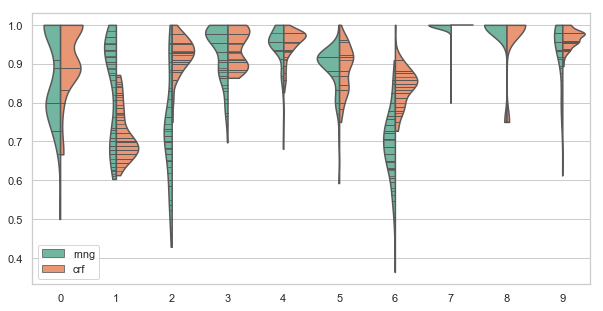

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.violinplot(ax=ax, 
               data=fscore_df, 
               x='sentence', 
               y='fscore', 
               hue='parser', 
               split=True, 
               palette='Set2', 
               inner='sticks',
               cut=0)
plt.savefig(os.path.join(OUTPATH, 'samples-fscore.pdf'))

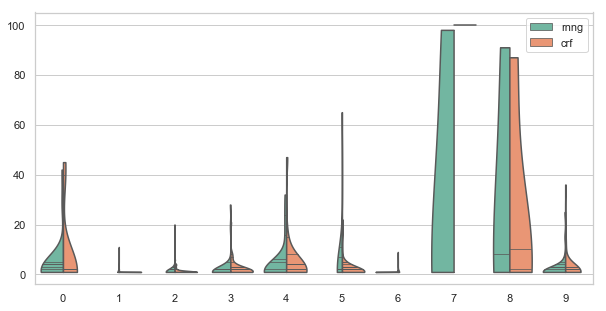

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.violinplot(ax=ax, 
               data=count_df, 
               x='sentence', 
               y='count', 
               hue='parser', 
               split=True, 
               palette='Set2', 
               inner='sticks',
               cut=0)
plt.savefig(os.path.join(OUTPATH, 'samples-count.pdf'))

## Dyer samples

In [9]:
dyer_samples_path = '../data/proposals/dyer-test.props'
dyer_samples = read_proposal_samples(dyer_samples_path)

dyer_logprob_df = make_logprob_dataframe(
    rnng_samples, dyer_samples, num_sents=NUM_SENTS)
dyer_fscore_df = make_fscore_dataframe(
    gold_trees, rnng_samples, dyer_samples, num_sents=NUM_SENTS)
dyer_count_df = make_count_dataframe(
    rnng_samples, dyer_samples, num_sents=NUM_SENTS)

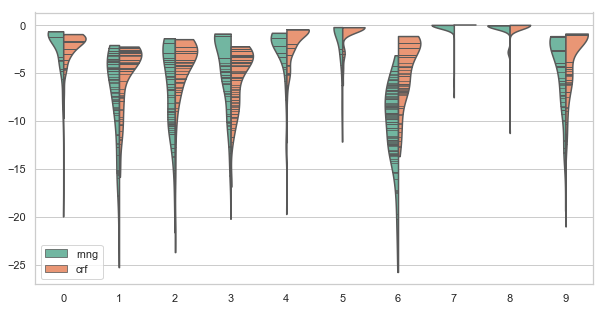

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.violinplot(ax=ax, 
               data=dyer_logprob_df, 
               x='sentence', 
               y='logprob', 
               hue='parser', 
               split=True, 
               palette='Set2', 
               inner='sticks',
               cut=0)
plt.savefig(os.path.join(OUTPATH, 'dyer-samples-logprob.pdf'))

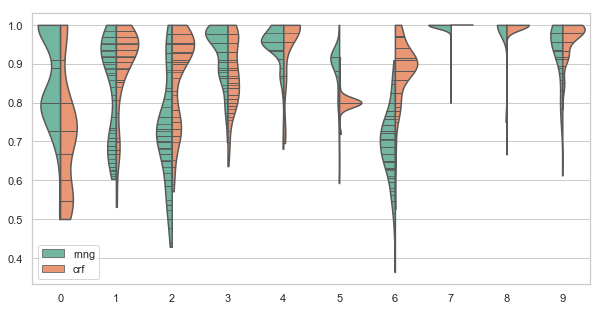

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.violinplot(ax=ax, 
               data=dyer_fscore_df, 
               x='sentence', 
               y='fscore', 
               hue='parser', 
               split=True, 
               palette='Set2', 
               inner='sticks',
               cut=0)
plt.savefig(os.path.join(OUTPATH, 'dyer-samples-fscore.pdf'))